In [14]:
import pandas as pd
import os 
from functions import to_minute, do_checkout
from datetime import timedelta
import seaborn as sns
import numpy as np

In [15]:
df = pd.read_csv('../data/thursday.csv', sep=';')
df.head()

,timestamp,customer_no,location
0,2019-09-05 07:00:00,1,drinks
1,2019-09-05 07:01:00,2,fruit
2,2019-09-05 07:01:00,3,dairy
3,2019-09-05 07:01:00,4,dairy
4,2019-09-05 07:02:00,1,checkout


In [16]:
def data_prep(df):
    """_summary_

    Args:
        df (_type_): _description_

    Returns:
        _type_: _description_
    """
    
    df_func = df.copy()
    df_func['timestamp'] = pd.to_datetime(df_func['timestamp'])

    return df_func

In [17]:
df = data_prep(df)
df.info(),df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5104 entries, 0 to 5103
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   timestamp    5104 non-null   datetime64[ns]
 1   customer_no  5104 non-null   int64         
 2   location     5104 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 119.8+ KB


(None, (5104, 3))

In [18]:
df.location.unique()

array(['drinks', 'fruit', 'dairy', 'checkout', 'spices'], dtype=object)

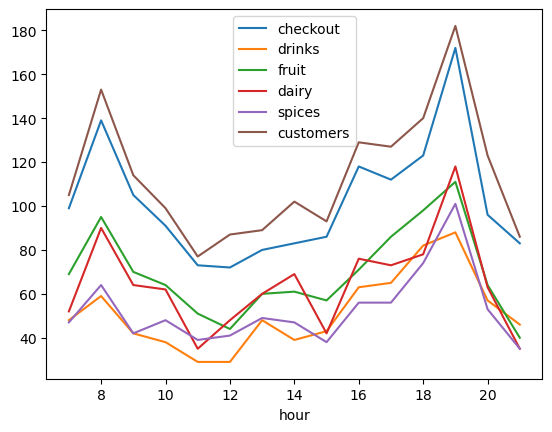

In [19]:
df_plot = df.copy()
df_plot['hour'] = df['timestamp'].dt.hour
df_plot[df['location'] == 'checkout'].groupby(['hour']).count().rename({'timestamp':'checkout'},axis=1)['checkout'].plot(legend=True)
df_plot[df['location'] == 'drinks'].groupby(['hour']).count().rename({'timestamp':'drinks'},axis=1)['drinks'].plot(legend=True)
df_plot[df['location'] == 'fruit'].groupby(['hour']).count().rename({'timestamp':'fruit'},axis=1)['fruit'].plot(legend=True)
df_plot[df['location'] == 'dairy'].groupby(['hour']).count().rename({'timestamp':'dairy'},axis=1)['dairy'].plot(legend=True)
df_plot[df['location'] == 'spices'].groupby(['hour']).count().rename({'timestamp':'spices'},axis=1)['spices'].plot(legend=True)
df_plot[['customer_no','hour']].groupby(['hour']).nunique().rename({'customer_no':'customers'},axis=1)['customers'].plot(legend=True);

In [20]:
# df['duration'] = df[['customer_no','timestamp']].groupby('customer_no').transform(lambda x: x.max() -x.min()) / pd.Timedelta(minutes=1)
# df.head()

In [21]:
#df[['customer_no','duration']].groupby('customer_no').min().plot()

In [22]:
df.tail()

,timestamp,customer_no,location
5099,2019-09-05 21:48:00,1533,dairy
5100,2019-09-05 21:48:00,1534,fruit
5101,2019-09-05 21:48:00,1535,spices
5102,2019-09-05 21:49:00,1534,checkout
5103,2019-09-05 21:49:00,1535,checkout


In [23]:
df_test=do_checkout(to_minute(df))
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11119 entries, 0 to 11118
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   customer_no  11119 non-null  int64         
 1   timestamp    11119 non-null  datetime64[ns]
 2   location     11119 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 260.7+ KB


In [24]:
# df_test['location'].unique()
# list = ['drinks', 'checkout', 'fruit', 'dairy', 'spices',np.nan]
# states = ['drinks', 'checkout', 'fruit', 'dairy', 'spices']

In [25]:
def create_next_location(df):
    """This function generates a shift(-1) column for a given dataframe 
    based on locations of the supermarket.

    Args:
        df (pd.Dataframe): Dataframe with timestamp data of re-netto

    Returns:
        pd.Dataframe: returns the same dataframe with an added column for next locations.
    """
    df_test = df.copy()
    states = df_test['location'].unique()
    list = [np.nan]
    for element in states:
        list.append(element)
    df_test.sort_values(by = 'customer_no', inplace=True)
    df_test['next_location'] = df_test['location'].shift(-1)
    df_temp = df_test[df_test['location']=='checkout'].copy()
    df_temp['next_location'].replace(to_replace = list, value='checkout',inplace=True)
    df_final = pd.concat([df_temp, df_test[df_test['location']!='checkout']],ignore_index=True)
    df_final.sort_values(by = 'timestamp', inplace=True)
    df_final.sort_values(by = 'customer_no', inplace=True)
    return df_final

In [26]:
df_next = create_next_location(df_test)

In [30]:
#check if sum = 1
states = df_next['location'].unique()
for state in states:
    print(f'Sum of Prob for {state} is {P.loc[state,:].sum()}')

Sum of Prob for drinks is 0.999
Sum of Prob for checkout is 1.0
Sum of Prob for fruit is 1.0
Sum of Prob for dairy is 1.0
Sum of Prob for spices is 0.9999999999999999


In [27]:
P = pd.crosstab(index=df_next['location'],columns=df_next['next_location'],normalize='index').round(3)
P

next_location,checkout,dairy,drinks,fruit,spices
location,,,,,
checkout,1.000,0.000,0.000,0.000,0.000
dairy,0.098,0.654,0.064,0.106,0.078
drinks,0.157,0.131,0.475,0.117,0.119
fruit,0.157,0.141,0.088,0.544,0.070
spices,0.133,0.211,0.173,0.135,0.348


In [28]:
P.loc['spices',:].sum()

0.9999999999999999

### Appendix

In [29]:
# def do_checkout(df):
#     """This fuction takes a dataframe, 
#     identifies the customer_no which did not check out yet
#     and returns a dataframe with the missing checkout-observations one minute after the last recorded observation.

#     Args:
#         df (pd.Dataframe): A dataframe of customer data within the re-netto supermarket. 
#         Expected columns: customer_no, timestamp, location

#     Returns:
#         pd.Dataframe: The same dataframe with appended lines of checkouts.
#     """
#     df_temp = df.copy()

#     id_gone = list(df_temp[df_temp['location'] == 'checkout']['customer_no'])
#     id_still_there = []
#     for id in df_temp['customer_no'].unique():
#         if id not in id_gone:
#             id_still_there.append(id)
#     df_return = df_temp.copy()
#     for id in id_still_there:
#         last_row = df_temp.tail(1).copy()
#         print(id)
#         last_row['customer_no'] = id
#         last_row['location'] = 'checkout'
#         last_row['timestamp'] = last_row['timestamp'] + timedelta(minutes=1)
#         print(last_row)
#         df_return = pd.concat([df_return,last_row],ignore_index=True)
#     return df_return







